# Загружаем библиотеки и датафрейм
---

In [1]:
%pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195851 sha256=30269292849d1bf0b485a75f5e36549ff8b7165c8eee4da52c91d02cc0e87128
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [1]:
import pandas as pd
import ast
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVDpp, accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
import seaborn as sns 


In [55]:
data = pd.read_parquet('train_mfti.parquet', engine='pyarrow')

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
data.head()

,event_date,event_timestamp,vacancy_id_,cookie_id,user_id,event_type
0,2022-08-01,1659323026,129850,97990f1a021d4be19aa3f955b7eacab4,951f53de61764ea0b51317200a0dbbfc,show_vacancy
1,2022-08-01,1659377255,108347,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
2,2022-08-01,1659376695,109069,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
3,2022-08-01,1659376722,171425,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
4,2022-08-01,1659374929,252384,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy


In [67]:
data.event_type.value_counts()

show_vacancy              6198889
preview_click_vacancy     4781280
click_response             384090
click_contacts             277584
preview_click_response     190635
click_favorite             155844
preview_click_favorite     107016
preview_click_contacts     102050
click_phone                 79191
preview_click_phone         16009
Name: event_type, dtype: int64

In [69]:
work_data.rating.value_counts()

0    6198889
1    4781280
4     384090
6     277584
5     190635
2     155844
3     107016
7     102050
8      79191
9      16009
Name: rating, dtype: int64

In [58]:
work_data = data.copy()

In [6]:
work_data.head()

,event_date,event_timestamp,vacancy_id_,cookie_id,user_id,event_type
0,2022-08-01,1659323026,129850,97990f1a021d4be19aa3f955b7eacab4,951f53de61764ea0b51317200a0dbbfc,show_vacancy
1,2022-08-01,1659377255,108347,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
2,2022-08-01,1659376695,109069,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
3,2022-08-01,1659376722,171425,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy
4,2022-08-01,1659374929,252384,03bf8c511fa949c79845a5d81b09aa1d,f5a2326a17484330aa8cb4019f1b1960,show_vacancy


In [68]:
work_data['rating'] = work_data['event_type'].map({'show_vacancy': 0,
                                     'preview_click_vacancy': 1,
                                     'click_favorite': 2,
                                     'preview_click_favorite': 3,
                                     'click_response': 4,
                                     'preview_click_response': 5,
                                     'click_contacts': 6,
                                     'preview_click_contacts': 7,
                                     'click_phone': 8,
                                     'preview_click_phone': 9})

In [70]:
df_ratings = work_data[['cookie_id', 'vacancy_id_', 'rating']]

In [71]:
df_test  = work_data[['cookie_id', 'vacancy_id_', 'rating']]

In [72]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12292588 entries, 0 to 12292587
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   cookie_id    object
 1   vacancy_id_  int64 
 2   rating       int64 
dtypes: int64(2), object(1)
memory usage: 281.4+ MB


In [73]:
df_ratings = df_ratings.groupby(['cookie_id','vacancy_id_'])['rating'].max().reset_index()

In [74]:
df_test = df_test.groupby(['cookie_id','vacancy_id_'])['rating'].max().reset_index()

In [75]:
df_test.head()

,cookie_id,vacancy_id_,rating
0,0000c4548c3944c08972bbdc1fa4eb85,137659,1
1,0000c4548c3944c08972bbdc1fa4eb85,153975,1
2,0000c4548c3944c08972bbdc1fa4eb85,174953,2
3,0000c4548c3944c08972bbdc1fa4eb85,176171,1
4,0000c4548c3944c08972bbdc1fa4eb85,182445,1


In [76]:
df_ratings.head()

,cookie_id,vacancy_id_,rating
0,0000c4548c3944c08972bbdc1fa4eb85,137659,1
1,0000c4548c3944c08972bbdc1fa4eb85,153975,1
2,0000c4548c3944c08972bbdc1fa4eb85,174953,2
3,0000c4548c3944c08972bbdc1fa4eb85,176171,1
4,0000c4548c3944c08972bbdc1fa4eb85,182445,1


In [77]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4678585 entries, 0 to 4678584
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   cookie_id    object
 1   vacancy_id_  int64 
 2   rating       int64 
dtypes: int64(2), object(1)
memory usage: 107.1+ MB


Начинаем преобразовывать характеристики

Text(0.5, 1.0, 'Распределение откликов по вакансиям')

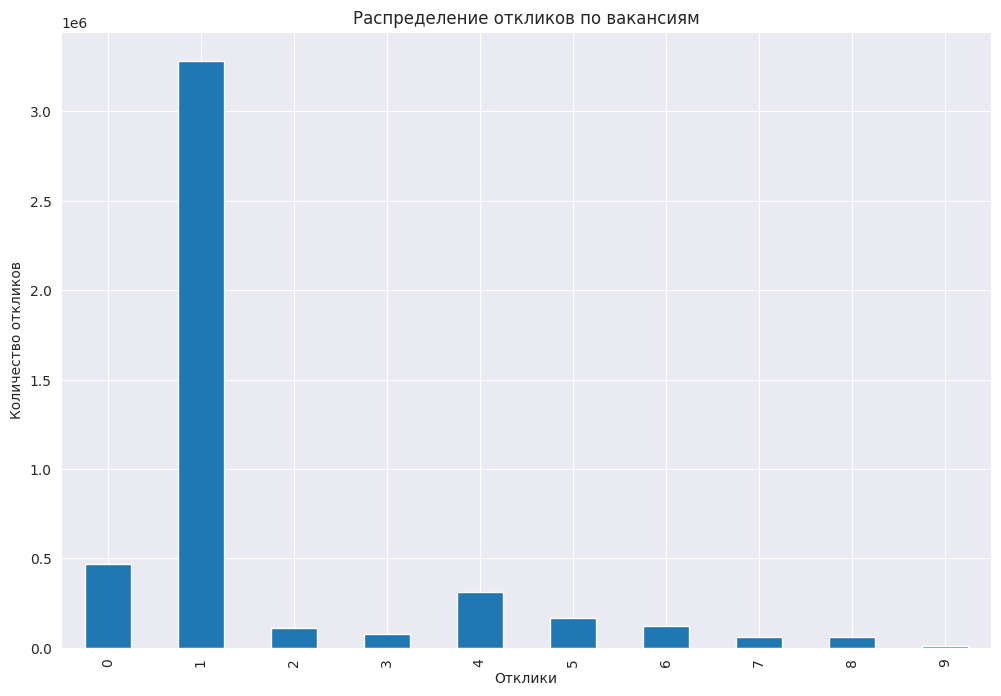

In [78]:
ratings_count = df_ratings['rating'].value_counts().sort_index(ascending=True)
 
plt.figure(figsize=(12,8))
 
ax = ratings_count.plot.bar()
 
ax.set_xlabel("Отклики")
 
ax.set_ylabel("Количество откликов")
 
ax.set_title("Распределение откликов по вакансиям")

In [79]:
df = df_ratings[['vacancy_id_','cookie_id']].groupby(['vacancy_id_']).agg(['count']).sort_values(('cookie_id','count'),ascending=False)

In [80]:
df.head()

,cookie_id
,count
vacancy_id_,
260154,18662
198114,16674
203404,16284
111505,15088
202608,14524


Text(0, 0.5, 'Количество кликов')

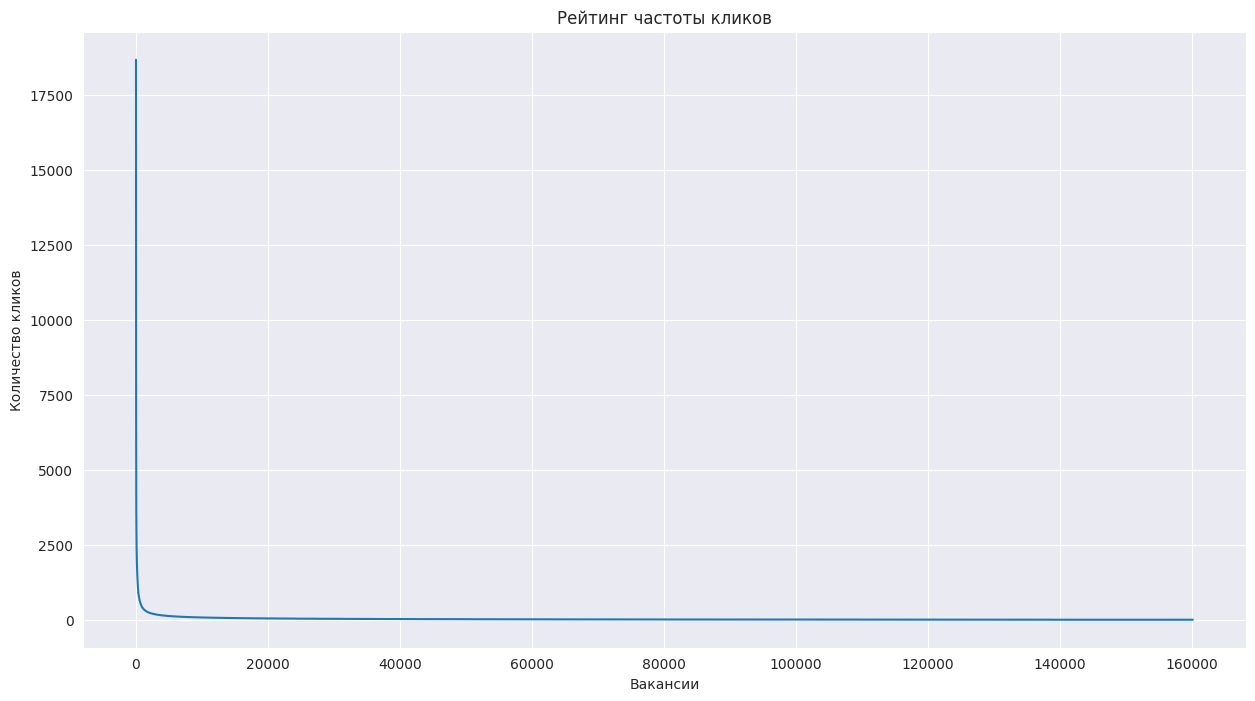

In [81]:
 
plt.figure(figsize=(15,8))
 
sns.set_style("darkgrid")
 
sns.lineplot(data=df[('cookie_id', 'count')].values)
 
plt.title("Рейтинг частоты кликов")
 
plt.xlabel("Вакансии")
 
plt.ylabel("Количество кликов")

Получается что очень большое количество вакансий просто просмотрены один раз

In [82]:
df.describe()

,cookie_id
,count
count,160167.000000
mean,29.210668
std,175.746648
min,1.000000
25%,4.000000
50%,10.000000
75%,23.000000
max,18662.000000


Выделим топовые вакансии

---

In [83]:
for i in range(20, 1000, 20):
    min_ratings = i
    count_min_ratings = count_min_ratings = len(df[df[('cookie_id', 'count')] >= min_ratings])
    print(f'Количество вакансий у которых более  {min_ratings} взаимодействий: {count_min_ratings}')

Количество вакансий у которых более  20 взаимодействий: 46418
Количество вакансий у которых более  40 взаимодействий: 22852
Количество вакансий у которых более  60 взаимодействий: 13939
Количество вакансий у которых более  80 взаимодействий: 9378
Количество вакансий у которых более  100 взаимодействий: 6845
Количество вакансий у которых более  120 взаимодействий: 5317
Количество вакансий у которых более  140 взаимодействий: 4241
Количество вакансий у которых более  160 взаимодействий: 3494
Количество вакансий у которых более  180 взаимодействий: 2948
Количество вакансий у которых более  200 взаимодействий: 2536
Количество вакансий у которых более  220 взаимодействий: 2210
Количество вакансий у которых более  240 взаимодействий: 1947
Количество вакансий у которых более  260 взаимодействий: 1746
Количество вакансий у которых более  280 взаимодействий: 1572
Количество вакансий у которых более  300 взаимодействий: 1445
Количество вакансий у которых более  320 взаимодействий: 1331
Количеств

Количество вакансий с которыми взаимодействовали более 20 раз составило 46418. Нам необходимо обрезать вакансии с которыми не было взаимодействий, что бы сделать наши рекомендации более релевантными:

In [84]:
min_ratings = 40
count_min_ratings = len(df[df[('cookie_id', 'count')] >= min_ratings])
 
print(f'Количество вакансий у которых более  {min_ratings} взаимодействий: {count_min_ratings}')

Количество вакансий у которых более  40 взаимодействий: 22852


In [85]:

df_top_vacancies = df[df[('cookie_id', 'count')] >= min_ratings]
 
df_ratings_with_top_vacancies = df_ratings[df_ratings['vacancy_id_'].isin(list(df_top_vacancies.index))]

In [86]:
df_ratings_with_top_vacancies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3217688 entries, 0 to 4678583
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   cookie_id    object
 1   vacancy_id_  int64 
 2   rating       int64 
dtypes: int64(2), object(1)
memory usage: 98.2+ MB


Выделим самых активных пользователей

---

In [87]:
# далее он у нас будет как df_users
df_1 = df_ratings[['cookie_id', 'vacancy_id_']].groupby(['cookie_id']).agg(['count']).sort_values(('vacancy_id_','count'),ascending=False)

Text(0, 0.5, 'Количество кликов')

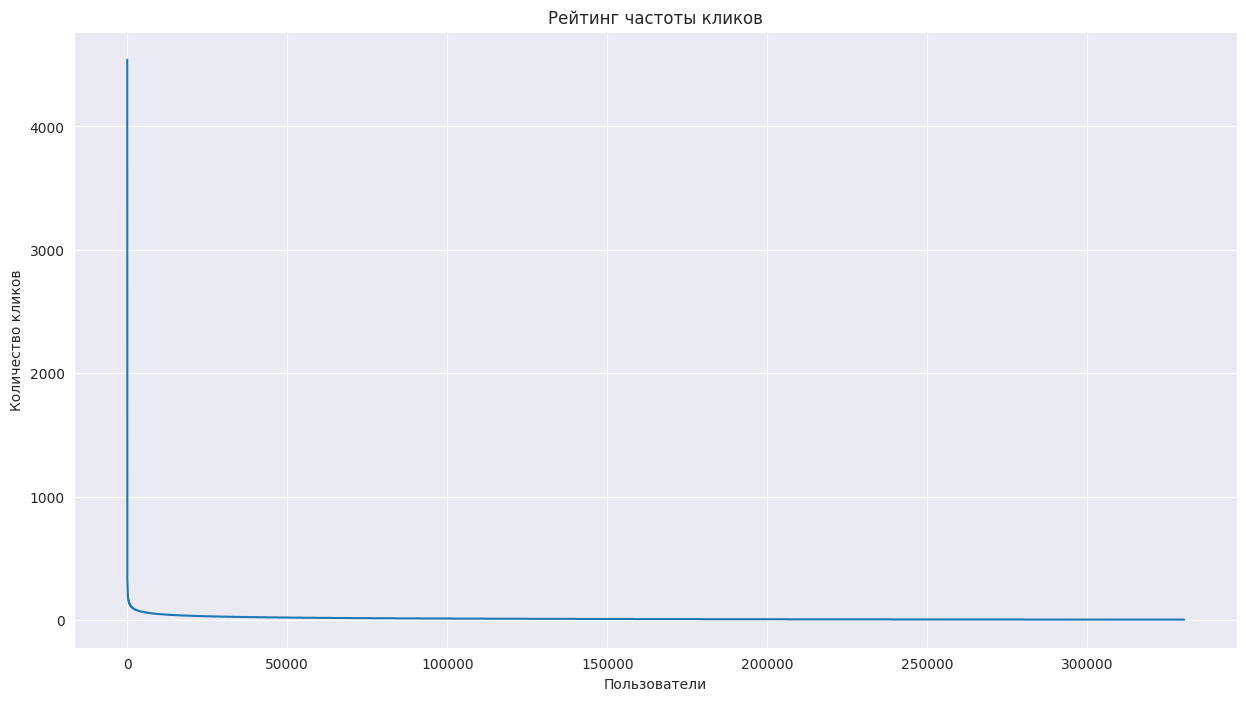

In [88]:
plt.figure(figsize=(15,8))
 
sns.set_style("darkgrid")
 
sns.lineplot(data=df_1[('vacancy_id_', 'count')].values)
 
plt.title("Рейтинг частоты кликов")
 
plt.xlabel("Пользователи")
 
plt.ylabel("Количество кликов")

In [89]:
for i in range(20, 1000, 20):
    min_ratings = i
    count_min_ratings = count_min_ratings = len(df_1[df_1[('vacancy_id_', 'count')] >= min_ratings])
    print(f'Количество клиентов у которых более  {min_ratings} взаимодействий: {count_min_ratings}')

Количество клиентов у которых более  20 взаимодействий: 58943
Количество клиентов у которых более  40 взаимодействий: 16435
Количество клиентов у которых более  60 взаимодействий: 6592
Количество клиентов у которых более  80 взаимодействий: 3133
Количество клиентов у которых более  100 взаимодействий: 1667
Количество клиентов у которых более  120 взаимодействий: 983
Количество клиентов у которых более  140 взаимодействий: 623
Количество клиентов у которых более  160 взаимодействий: 397
Количество клиентов у которых более  180 взаимодействий: 283
Количество клиентов у которых более  200 взаимодействий: 198
Количество клиентов у которых более  220 взаимодействий: 159
Количество клиентов у которых более  240 взаимодействий: 124
Количество клиентов у которых более  260 взаимодействий: 98
Количество клиентов у которых более  280 взаимодействий: 74
Количество клиентов у которых более  300 взаимодействий: 58
Количество клиентов у которых более  320 взаимодействий: 42
Количество клиентов у кот

Для повышения релевантности так же исключим, пользователей которые имеют менее 40 взаимодействий.

In [90]:
# минимальное количество просмотренных вакансий
min_vacancies_rated = 40
# создадим датасет пользоватлей с агрегацией по пользователям 
df_users = df_ratings_with_top_vacancies[['vacancy_id_','cookie_id']].groupby(['cookie_id']).agg(['count']).sort_values(('vacancy_id_','count'),ascending=False)
 
# выберем пользователей у которых более 200 взаимодействий (мы хотим рекомендовать то что смотрят активные пользователи)
df_top_rating_users = df_users[df_users[('vacancy_id_', 'count')]>=min_vacancies_rated]

# нас будут интересовать только id пользоватлей возьмем их в список 
top_rating_users = list(df_top_rating_users.index)

# в итоговый датасет войдут только взаимодействия топ пользоватлей с топ вакансиями 
df_final = df_ratings_with_top_vacancies[df_ratings_with_top_vacancies['cookie_id'].isin(top_rating_users)]

In [91]:
df_final.head()

,cookie_id,vacancy_id_,rating
442,000821e2fd4a4a28a10596bfdeac6534,100495,1
443,000821e2fd4a4a28a10596bfdeac6534,100697,1
446,000821e2fd4a4a28a10596bfdeac6534,110708,1
448,000821e2fd4a4a28a10596bfdeac6534,113239,1
449,000821e2fd4a4a28a10596bfdeac6534,114247,1


In [92]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527045 entries, 442 to 4678485
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   cookie_id    527045 non-null  object
 1   vacancy_id_  527045 non-null  int64 
 2   rating       527045 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 16.1+ MB


In [ ]:
df_final.to_parquet('item_based')

In [ ]:
df_final = pd.read_parquet('item_based')

Возьмем за основу наш базовый датасет, он учится очень бысто

In [93]:
minimum_rating = min(df_final['rating'].values)
 
maximum_rating = max(df_final['rating'].values)
 
print(f'Minimum/maximum оценки: {minimum_rating}/{maximum_rating}')

Minimum/maximum оценки: 0/9


In [94]:
reader = Reader(rating_scale=(minimum_rating,maximum_rating))
 
data = Dataset.load_from_df(df_final[['cookie_id', 'vacancy_id_', 'rating']], reader)

In [95]:
trainset = data.build_full_trainset()

In [96]:
# обучаем алгоритм
algo = SVD()

algo.fit(trainset)

### Это блок для тестирования данных не выполнять когда делаем финальный прогноз
---

In [97]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_testset()
predictions = algo.test(testset)

In [98]:
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 0.8078
0.8078281474667061
MAE:  0.5518
0.5518035064451353


In [43]:
test = pd.read_parquet('test_public_mfti.parquet', engine='pyarrow')

In [44]:
test_list = list(test['cookie_id'])
print(test_list[:5])

['000cd76cd33f43d4a1ac1d16d10f8bf7', '0034bc7f404341ba8412665453e7825a', '00a6c5a64a274c55a836402bdeb3b2c4', '015937a125b14e74bdff1cddc49f9172', '01de50c280794cec8804f16f45f847b7']


In [102]:
df_final = df_test

In [101]:
def get_prediction_for_list(user_list, model = algo, set_n = 5):
    top_n = {}
    
    for user_id in user_list:
        user_items = df_final[df_final['cookie_id'] == user_id]['vacancy_id_'].unique()  # взаимодействия пользователя
        candidates = df_final[~df_final['cookie_id'].isin(user_items)]['vacancy_id_'].unique()  # вакансии, с которыми пользователь не взаимодействовал
        testset = [[user_id, item_id, 9] for item_id in candidates]  # создание тестовой выборки
        predictions = model.test(testset)
        top_n[user_id] = sorted(predictions, key=lambda x: x.est, reverse=True)[:set_n]  # получение топ-5 рекомендаций

    # формирование результата в виде датафрейма
    result = pd.DataFrame(columns=['cookie_id', 'top_recommendations'])
    for user_id, predictions in top_n.items():
        item_list = [pred.iid for pred in predictions]
        result = result.append({'cookie_id': user_id, 'top_recommendations': item_list}, ignore_index=True)

    return result
    

In [ ]:
test_prediction = get_prediction_for_list(test_list)

In [48]:
def precision_n(predictions,df_test_list_top, k=5):
  #recommendations num:
    n_rec_k = len(df_test_list_top)*k
  #true reccomendations:
    matches=0
    for row in range(len(predictions)):
      row_match = set(predictions['top_recommendations'][row]).intersection(set(df_test_list_top['vacancy_id_'][row]))  
      matches += len(row_match)
  #Results:
    precisions = matches / n_rec_k if n_rec_k != 0 else 0
    return precisions

In [105]:
precision_n(test_prediction, test)

0.007512953367875648

In [104]:
test_prediction.tail(100)

,cookie_id,top_recommendations
672,dd8f35428911409f902b484964dd4ee4,"[244770, 222548, 182870, 181928, 177345]"
673,ddb704add14a4f06ab6d6cb55f9111c7,"[244770, 222548, 182870, 181928, 177345]"
674,de042bdb60b649109c2a1a35247adac5,"[244770, 222548, 182870, 181928, 177345]"
675,def7ca6b59b04264829d44e33df41c7e,"[244770, 222548, 182870, 181928, 177345]"
676,df524ce1312e4200ac6e57538e2485c7,"[191046, 106676, 251260, 236890, 245952]"
...,...,...
767,fdbcda17f22f406486837059e76c7fed,"[244770, 222548, 182870, 181928, 177345]"
768,fe6193ab26494ace9be5aae36e507618,"[244770, 222548, 182870, 181928, 177345]"
769,fe95b2826ee1452b81201ed3f4c3294d,"[244770, 222548, 182870, 181928, 177345]"
770,ff1aef256a49481698bb2e938510ff36,"[244770, 222548, 182870, 181928, 177345]"


In [52]:
test_prediction.tail(100)

,cookie_id,top_recommendations
672,dd8f35428911409f902b484964dd4ee4,"[235677, 174953, 221920, 219948, 180382]"
673,ddb704add14a4f06ab6d6cb55f9111c7,"[235677, 174953, 221920, 219948, 180382]"
674,de042bdb60b649109c2a1a35247adac5,"[235677, 174953, 221920, 219948, 180382]"
675,def7ca6b59b04264829d44e33df41c7e,"[235677, 174953, 221920, 219948, 180382]"
676,df524ce1312e4200ac6e57538e2485c7,"[180382, 219948, 193331, 235677, 128776]"
...,...,...
767,fdbcda17f22f406486837059e76c7fed,"[235677, 174953, 221920, 219948, 180382]"
768,fe6193ab26494ace9be5aae36e507618,"[235677, 174953, 221920, 219948, 180382]"
769,fe95b2826ee1452b81201ed3f4c3294d,"[235677, 174953, 221920, 219948, 180382]"
770,ff1aef256a49481698bb2e938510ff36,"[235677, 174953, 221920, 219948, 180382]"


### Блок проверки модели
---

In [36]:
def precision_recall_at_k(predictions, k=5, threshold=0.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [37]:
from surprise.model_selection import KFold

In [100]:
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))

0.1577468115257437
0.1509112738151467
0.14847071327349992
0.15393441977641295
0.14997834986616243


### Сохранение и загрузка модели

---

In [ ]:
## SAVING TRAINED MODEL
from surprise import dump
import os
model_filename = "./model.pickle"
print (">> Starting dump")
# Dump algorithm and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=algo)
print (">> Dump done")
print(model_filename)

In [ ]:
## LOAD SAVED MODEL
def load_model(model_filename):
    print (">> Loading dump")
    from surprise import dump
    import os
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    print (">> Loaded dump")
    return loaded_model